In [ ]:
!wget -q https://www.dropbox.com/s/63j3myz3hobc8cu/PASCAL_VOC.zip

In [ ]:
!unzip PASCAL_VOC.zip

Archive:  PASCAL_VOC.zip
   creating: PASCAL_VOC/
  inflating: PASCAL_VOC/pascal_test2007.json  
  inflating: PASCAL_VOC/pascal_train2007.json  
  inflating: PASCAL_VOC/pascal_train2012.json  
  inflating: PASCAL_VOC/pascal_val2007.json  
  inflating: PASCAL_VOC/pascal_val2012.json  


In [ ]:
import json
train_data=json.load(open("/content/PASCAL_VOC/pascal_train2007.json"))
train_data.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [ ]:
categories= [k["name"] for k in train_data['categories']]
print(categories)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train_data2= {}
for k in train_data['annotations']:
  if k['ignore']==0:
    bb=k['bbox']
    bb=np.array([bb[1],bb[0],bb[1]+bb[3]-1,bb[0]+bb[2]-1])
    if k['image_id'] not in list(train_data2.keys()):
      train_data2[k['image_id']] = []
    train_data2[k['image_id']].append((bb,k['category_id']))

train_data2

In [ ]:
train_data2[3367]

[(array([173,   0, 252,  37]), 15),
 (array([212,  14, 301, 110]), 14),
 (array([166, 353, 266, 388]), 16),
 (array([129, 386, 169, 417]), 16),
 (array([127, 421, 170, 446]), 16),
 (array([141, 475, 172, 495]), 16)]

In [ ]:
def get_largest(b):
  out = sorted(b,key=lambda x:np.prod(x[0][-2:] - x[0][:2]), reverse=True)
  return out

In [ ]:
get_largest(train_data2[3367])

[(array([212,  14, 301, 110]), 14),
 (array([166, 353, 266, 388]), 16),
 (array([173,   0, 252,  37]), 15),
 (array([129, 386, 169, 417]), 16),
 (array([127, 421, 170, 446]), 16),
 (array([141, 475, 172, 495]), 16)]

In [ ]:
train_data3 = {}
for k in list(train_data2.keys()):
  train_data3[k] = []
  train_data3[k].append(get_largest(train_data2[k])[0])

train_data3

In [ ]:
categories[train_data3[3699][0][1]]

'pottedplant'

In [ ]:
data = {"file_name":list(train_data3.keys())}

df = pd.DataFrame(data)
df['category'] = [categories[train_data3[j][0][1]-1] for j in list(df["file_name"])]
df['cat_id'] = [train_data3[j][0][1] for j in list(df["file_name"])]
df['bbox'] = [train_data3[j][0][0] for j in list(df["file_name"])]
df.head()

,file_name,category,cat_id,bbox
0,12,car,7,"[96, 155, 269, 350]"
1,17,horse,13,"[77, 89, 335, 402]"
2,23,person,15,"[1, 2, 461, 242]"
3,26,car,7,"[124, 89, 211, 336]"
4,32,aeroplane,1,"[77, 103, 182, 374]"


In [ ]:
df.to_pickle('labels.p')
df.to_csv('labels_pascal_voc.csv')

#Data Collection

In [ ]:
!wget -q https://www.dropbox.com/s/18ivvmbq5r3ejr1/VOC2007.zip
!unzip VOC2007.zip

#Data Exploration

In [ ]:
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_pickle("/content/labels.p")
df.shape

(2501, 4)

In [ ]:
df.head()

,file_name,category,cat_id,bbox
0,12,car,7,"[96, 155, 269, 350]"
1,17,horse,13,"[77, 89, 335, 402]"
2,23,person,15,"[1, 2, 461, 242]"
3,26,car,7,"[124, 89, 211, 336]"
4,32,aeroplane,1,"[77, 103, 182, 374]"


In [ ]:
def explore(img_name):
  img = plt.imread("/content/VOC2007/JPEGImages/"+img_name)
  fn = int(img_name[:-4])
  bb = list(df['bbox'][df['file_name']==fn])[0]
  print(img.shape)
  print(bb)
  plt.subplot(121)
  plt.imshow(img)
  cv2.rectangle(img,(bb[1],bb[0]),(bb[3],bb[2]),[0,0,255],5)
  plt.subplot(122)
  plt.imshow(img)
  plt.show()

(333, 500, 3)
[ 96 155 269 350]


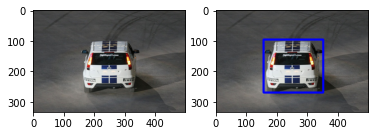

In [ ]:
explore('000012.jpg')

(281, 500, 3)
[ 77 103 182 374]


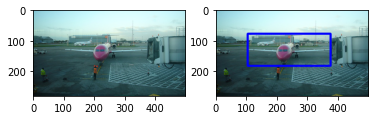

In [ ]:
explore('000032.jpg')

In [ ]:
import imgaug as ig
from imgaug import augmenters as ag

In [ ]:
def augment(img,bb):
  aug = ag.Resize({'height':200,'width':200}).to_deterministic()
  bb_old = ig.BoundingBoxesOnImage([ig.BoundingBox(x1=bb[1],y1=bb[0],x2=bb[3],y2=bb[2])],shape=img.shape)
  #Converting image to 200x200
  new_img = aug.augment_images([img])[0]
  #Augmenting bounding boxes
  new_bb = aug.augment_bounding_boxes([bb_old])[0]
  new_bb = [new_bb.bounding_boxes[0].x1,new_bb.bounding_boxes[0].y1,
            new_bb.bounding_boxes[0].x2,new_bb.bounding_boxes[0].y2]
  return new_img,new_bb

In [ ]:
def explore(img_name):
  img = plt.imread("/content/VOC2007/JPEGImages/"+img_name)
  fn = int(img_name[:-4])
  bb = list(df['bbox'][df['file_name']== fn])[0]
  print(img.shape)
  print(bb)
  new_img,new_bb = augment(img,bb)
  print(new_img.shape)
  print(new_bb)
  plt.subplot(121)
  plt.imshow(img)
  cv2.rectangle(img,(bb[1],bb[0]),(bb[3],bb[2]),[0,0,255],5)
  plt.subplot(122)
  plt.imshow(img)
  plt.show()
  plt.subplot(121)
  plt.imshow(new_img)
  cv2.rectangle(new_img,(new_bb[0],new_bb[1]),(new_bb[2],new_bb[3]),[0,0,255],2)
  plt.subplot(122)
  plt.imshow(new_img)
  plt.show()

(333, 500, 3)
[ 96 155 269 350]
(200, 200, 3)
[62.0, 57.657658, 140.0, 161.56155]


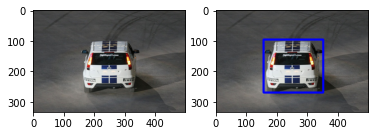

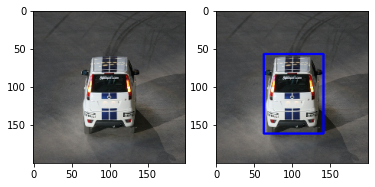

In [ ]:
explore('000012.jpg')

(500, 375, 3)
[ 42  74 495 205]
(200, 200, 3)
[39.466667, 16.8, 109.333336, 198.0]


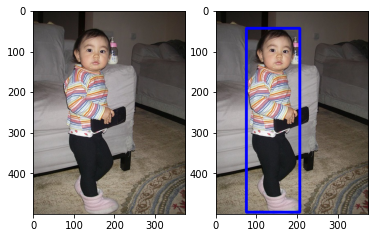

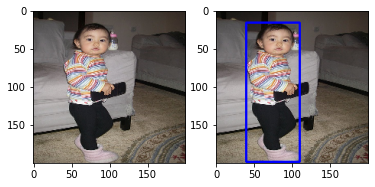

In [ ]:
explore("002545.jpg")

#Dataset Prepration

In [ ]:
df.head()

,file_name,category,cat_id,bbox
0,12,car,7,"[96, 155, 269, 350]"
1,17,horse,13,"[77, 89, 335, 402]"
2,23,person,15,"[1, 2, 461, 242]"
3,26,car,7,"[124, 89, 211, 336]"
4,32,aeroplane,1,"[77, 103, 182, 374]"


In [ ]:
df['file_name'] = df['file_name'].astype(str)
df['file_name'] = df['file_name'].str.zfill(6)
df.head()

,file_name,category,cat_id,bbox
0,000012,car,7,"[96, 155, 269, 350]"
1,000017,horse,13,"[77, 89, 335, 402]"
2,000023,person,15,"[1, 2, 461, 242]"
3,000026,car,7,"[124, 89, 211, 336]"
4,000032,aeroplane,1,"[77, 103, 182, 374]"


In [ ]:
df['cat_id'].unique()

array([ 7, 13, 15,  1, 19, 12,  9,  4,  3, 16,  8, 18, 14, 20,  6, 17, 11,
        5, 10,  2])

In [ ]:
df['cat_id'] = df['cat_id'] - 1

In [ ]:
from tensorflow.keras.applications import resnet50

In [ ]:
#Loading and preparing dataset
x = []
y1 = []
y2 = []

for i in range(df.shape[0]):
  img = plt.imread("/content/VOC2007/JPEGImages/" + df['file_name'][i]+".jpg")
  img,bb = augment(img,df['bbox'][i])
  img = resnet50.preprocess_input(img)
  x.append(img)
  y1.append(df['cat_id'][i])
  y2.append(bb)

In [ ]:
x = np.array(x)
print(x.shape)
y1 = to_categorical(y1)
print(y1.shape)
y2 = np.array(y2)
print(y2.shape)

(2501, 200, 200, 3)
(2501, 20)
(2501, 4)


#Building Model using Transfer Learning

In [ ]:
from tensorflow.keras import models,layers

In [ ]:
input_layer = layers.Input(shape=(200,200,3))
resmodel = resnet50.ResNet50(weights="imagenet",input_tensor=input_layer,include_top=False)
for layer in resmodel.layers[:-5]:
  layer.trainable=False

In [ ]:
last_layer = resmodel.layers[-1].output

flatten = layers.Flatten()(last_layer)

#Classification Segment
dropout1 = layers.Dropout(0.5)(flatten) 
dense1 = layers.Dense(120,activation='relu')(dropout1)
out1 = layers.Dense(20,activation='softmax',name="classes")(dense1)

#Regression Segment
dropout2 = layers.Dropout(0.5)(flatten)
dense2 = layers.Dense(120,activation='relu')(dropout2)
out2 = layers.Dense(4,activation='relu',name="bbox")(dense2)

model = models.Model(inputs=input_layer,outputs=[out1,out2])
model.summary()


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

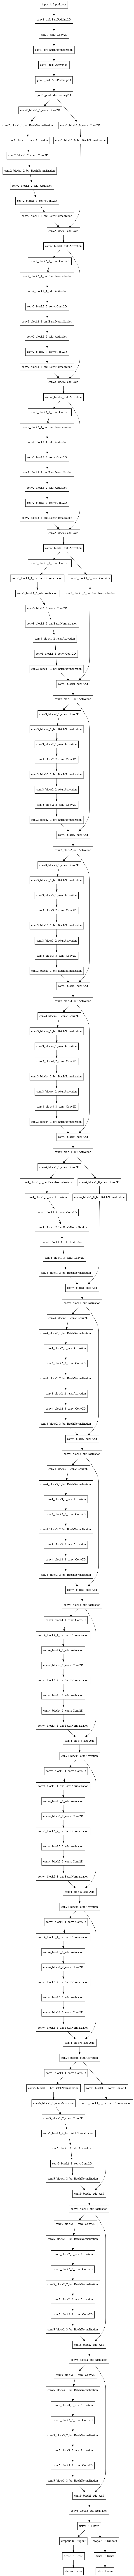

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile(optimizer='adam',loss={"classes":"categorical_crossentropy","bbox":"mae"},
              metrics={"classes":"accuracy"},loss_weights={"classes":4,"bbox":1})

In [ ]:
model.fit(x=x,y=[y1,y2],epochs=10,batch_size=64,shuffle=True,validation_split=0.2)

Epoch 1/10
32/32 [==============================] - 8s 259ms/step - loss: 56.1565 - classes_loss: 4.5901 - bbox_loss: 37.7959 - classes_accuracy: 0.4695 - val_loss: 36.3641 - val_classes_loss: 1.5544 - val_bbox_loss: 30.1463 - val_classes_accuracy: 0.5689
Epoch 2/10
32/32 [==============================] - 7s 214ms/step - loss: 28.4649 - classes_loss: 0.7444 - bbox_loss: 25.4873 - classes_accuracy: 0.7755 - val_loss: 33.8390 - val_classes_loss: 1.4438 - val_bbox_loss: 28.0637 - val_classes_accuracy: 0.6727
Epoch 3/10
32/32 [==============================] - 7s 216ms/step - loss: 23.5612 - classes_loss: 0.2935 - bbox_loss: 22.3872 - classes_accuracy: 0.9070 - val_loss: 33.7304 - val_classes_loss: 1.5150 - val_bbox_loss: 27.6705 - val_classes_accuracy: 0.7046
Epoch 4/10
32/32 [==============================] - 7s 221ms/step - loss: 21.6856 - classes_loss: 0.1193 - bbox_loss: 21.2083 - classes_accuracy: 0.9665 - val_loss: 33.7458 - val_classes_loss: 1.3860 - val_bbox_loss: 28.2019 - val_c

In [ ]:
def predict(img_name):
  img = image.load_img(img_name,target_size=(200,200))
  img = image.img_to_array(img)
  img2 = img.copy()
  img = resnet50.preprocess_input(img)
  prediction = model.predict(img.reshape(1,200,200,3))
  class_id = np.argmax(prediction[0])
  text = df['category'][df['cat_id']==class_id].unique()[0]
  print(class_id,text)
  bb = prediction[1][0]
  print(bb)
  cv2.rectangle(img2,(bb[0],bb[1]),(bb[2],bb[3]),[0,0,255],2)
  cv2.putText(img2,text,(int(bb[0]-5),int(bb[1]-5)),cv2.FONT_HERSHEY_SIMPLEX,0.5,1)
  plt.imshow(img2.astype('int32'))
  plt.show()



In [ ]:
!wget -q https://cdn.pixabay.com/photo/2016/01/19/17/55/horses-1149974__340.jpg

12 horse
[  0.        26.288637 143.34546  176.83809 ]


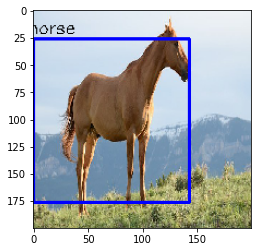

In [ ]:
predict('horses-1149974__340.jpg')

In [ ]:
model.save("model.h5")
model.save_weights("model_weights.h5")